# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mlwpy_video_extras import (regression_errors, 
                                regression_residuals)

import collections as co
import itertools as it

In [2]:
from sklearn import (datasets,
                     dummy,
                     linear_model,
                     metrics,
                     model_selection as skms,
                     neighbors,
                     pipeline,
                     preprocessing as skpre)

In [3]:
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# Baseline Regressors

In [4]:
diabetes = datasets.load_diabetes()

tts = skms.train_test_split(diabetes.data, diabetes.target, 
                            test_size=.25, random_state=42)

(diabetes_train_ftrs, diabetes_test_ftrs, 
 diabetes_train_tgt,  diabetes_test_tgt) = tts

In [5]:
baseline = dummy.DummyRegressor(strategy='mean')
baseline = dummy.DummyRegressor(strategy='median')

In [6]:
strategies = ['constant', 'quantile', 'mean', 'median', ]
baseline_args = [{"strategy":s} for s in strategies]

# additional args for constant and quantile
baseline_args[0]['constant'] = 50.0
baseline_args[1]['quantile'] =  0.75

# helper to unpack arguments for each DummyRegresor and 
# do a fit-predict-eval sequence
def do_one_diabetes(**args):
    baseline = dummy.DummyRegressor(**args)
    baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
    base_preds = baseline.predict(diabetes_test_ftrs)
    return metrics.mean_squared_error(base_preds, diabetes_test_tgt)

# gather all results via a list comprehension
mses = [do_one_diabetes(**bla) for bla in baseline_args]

display(pd.DataFrame({'mse':mses,
                      'rmse':np.sqrt(mses)}, 
                     index=strategies))

,mse,rmse
constant,"14,657.6847",121.0689
quantile,"10,216.3874",101.0761
mean,"5,607.1979",74.8812
median,"5,542.2252",74.4461


# Regression Metrics

##### Custom Metrics and RMSE

In [7]:
# we could define mean_squared_error as:
# sse = np.sum((actual - predicted)**2)  [sum-of-squared errors]
# mse = sse / len(actual)

def rms_error(actual, predicted):
    ' root-mean-squared-error function '
    # lesser values are better (a<b ... a is better)
    mse = metrics.mean_squared_error(actual, predicted)
    return np.sqrt(mse)

def neg_rmse_score(actual, predicted):
    ' rmse based score function '
    #  greater values are better  (a<b ... b better)
    return -rms_error(actual, predicted)

# routines like cross_val_score need a "scorer"
def neg_rmse_scorer(model, ftrs, tgt_actual):
    ' rmse scorer suitable for scoring arg '
    tgt_pred = model.predict(ftrs)
    return neg_rmse_score(tgt_actual, tgt_pred)

In [8]:
knn = neighbors.KNeighborsRegressor(n_neighbors=3)
skms.cross_val_score(knn, diabetes.data, diabetes.target,
                     scoring=neg_rmse_scorer)

array([-58.07341774, -67.43002106, -62.28861222, -62.02315061,
       -67.25015489])

In [9]:
metrics.SCORERS['neg_mean_squared_error']

make_scorer(mean_squared_error, greater_is_better=False)

In [10]:
knn = neighbors.KNeighborsRegressor(n_neighbors=3)
nrmse = skms.cross_val_score(knn, diabetes.data, diabetes.target, 
                            scoring='neg_root_mean_squared_error')
nrmse

array([-58.07341774, -67.43002106, -62.28861222, -62.02315061,
       -67.25015489])

In [11]:
# the primary regression metrics available
[k for k in metrics.SCORERS.keys() if k.endswith('error')]

['max_error',
 'neg_median_absolute_error',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_root_mean_squared_error']

### Understanding the Default Regression Metric $R^2$

In [12]:
lr = linear_model.LinearRegression()

# help(lr.score) #for full output
print(lr.score.__doc__.splitlines()[0])

Return the coefficient of determination R^2 of the prediction.


$$R^2 = 1 - \frac{{SSE}_{our\ predictions}}{{SSE}_{mean\ as\ prediction}}$$

In [13]:
# where does the mean come from!?!  
# calculate the mean on the training set and evaluate on the test set
# calculate the mean on the **test** set and evaluate on the test set

errors_mean_train_on_train = np.mean(diabetes_train_tgt) - diabetes_train_tgt
errors_mean_train_on_test  = np.mean(diabetes_train_tgt) - diabetes_test_tgt
errors_mean_test_on_test   = np.mean(diabetes_test_tgt)  - diabetes_test_tgt

In [14]:
# calculate sum-of-squared-errors two ways:
via_manual = (errors_mean_train_on_train**2).sum()
via_npdot  = np.dot(errors_mean_train_on_train, 
                    errors_mean_train_on_train)
np.allclose(via_manual, via_npdot)

True

In [15]:
def sse(errors):
    return np.sum(errors**2)  # you'll np.dot()

In [16]:
sse_mean_train_on_train = sse(errors_mean_train_on_train)
sse_mean_train_on_test  = sse(errors_mean_train_on_test)
sse_mean_test_on_test   = sse(errors_mean_test_on_test)

In [17]:
print("mean train on train:", sse_mean_train_on_train)
print("mean train on test:",  sse_mean_train_on_test)
print("mean test on test:  ", sse_mean_test_on_test)

mean train on train: 2000770.7371601206
mean train on test: 622398.9703179052
mean test on test:   613795.5675675675


In [18]:
# now, imagine we have a simple linear regression model:
lr = linear_model.LinearRegression()

lr_preds = (lr.fit(diabetes_train_ftrs, diabetes_train_tgt)
           .predict(diabetes_test_ftrs))
lr_r2 = metrics.r2_score(diabetes_test_tgt, lr_preds)
lr_r2

0.48490866359058016

In [19]:
# compare 
# the sse of linear_regression trained on train, evaluated on test
sse_lr = sse(lr_preds-diabetes_test_tgt)

# the sse of baseline-mean     trained on *test*, evaluated on test
sse_mean_test_on_test = sse(errors_mean_test_on_test)

In [20]:
1 - (sse_lr/sse_mean_test_on_test)

0.48490866359058016

In [21]:
# we can demonstrate that with builtins:
base_model = dummy.DummyRegressor(strategy='mean')
base_model.fit(diabetes_test_ftrs, diabetes_test_tgt)   # WARNING!  this is the weird step!
base_model_test_preds = base_model.predict(diabetes_test_ftrs)

# you might notice we use MSE instead of SSE:  
# it's ok, because we'll do it in two places and a factor of (1/n) will simply cancel out
base_model_mse = metrics.mean_squared_error(diabetes_test_tgt,
                                            base_model_test_preds)
print(base_model_mse)

5529.689797906013


In [22]:
models = {'knn': neighbors.KNeighborsRegressor(n_neighbors=3),
          'lr' : linear_model.LinearRegression()}
results = co.defaultdict(dict)
for name in models:
    m = models[name]
    preds = (m.fit(diabetes_train_ftrs, diabetes_train_tgt)
              .predict(diabetes_test_ftrs))
             
    results[name]['r2']  = metrics.r2_score(diabetes_test_tgt, preds)
    results[name]['mse'] = metrics.mean_squared_error(diabetes_test_tgt, preds)

df = pd.DataFrame(results).T
df['r2 via mse'] = 1 - (df['mse'] / base_model_mse)
display(df)

,r2,mse,r2 via mse
knn,0.3722,"3,471.4194",0.3722
lr,0.4849,"2,848.2953",0.4849


# Errors and Residuals

In [23]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                       'actual'    : [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error
example,,,
0,4,3,1
1,2,5,-3
2,9,7,2


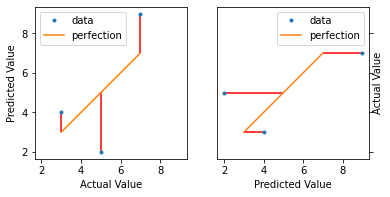

In [24]:
regression_errors((6,3), ape_df.predicted, ape_df.actual)

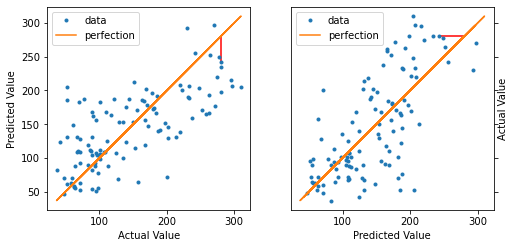

In [25]:
lr  = linear_model.LinearRegression()
preds = (lr.fit(diabetes_train_ftrs, diabetes_train_tgt)
           .predict(diabetes_test_ftrs))

regression_errors((8,4), preds, diabetes_test_tgt, errors=[-20]) 

In [26]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                       'actual'    : [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']
ape_df['resid'] = ape_df['actual'] - ape_df['predicted']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error,resid
example,,,,
0,4,3,1,-1
1,2,5,-3,3
2,9,7,2,-2


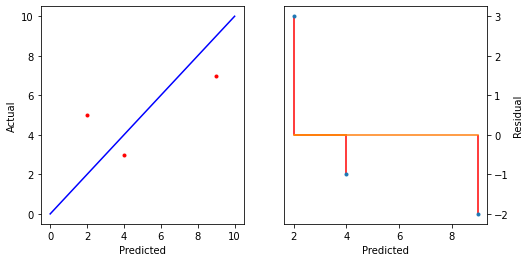

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.plot(ape_df.predicted, ape_df.actual, 'r.', # pred v actual
         [0,10], [0,10], 'b-')                  # perfect line
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
regression_residuals(ax2, ape_df.predicted, ape_df.actual, 
                     'all', right=True) 

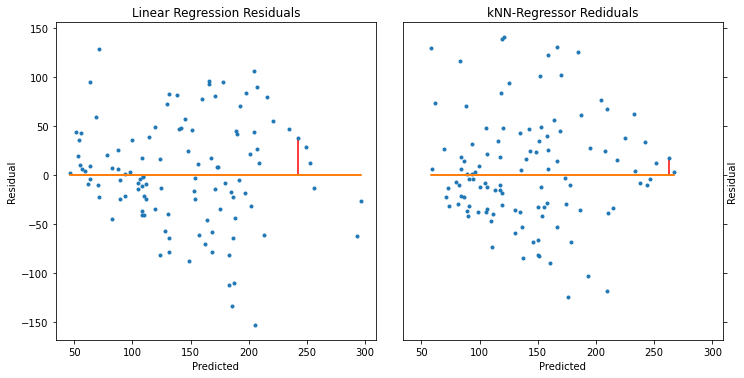

In [28]:
lr  = linear_model.LinearRegression()
knn = neighbors.KNeighborsRegressor()

models = [lr, knn]

fig, axes = plt.subplots(1, 2, figsize=(10,5), 
                         sharex=True, sharey=True)
fig.tight_layout()

for model, ax, on_right in zip(models, axes, [False, True]):
    preds = (model.fit(diabetes_train_ftrs, diabetes_train_tgt)
                  .predict(diabetes_test_ftrs))
    
    regression_residuals(ax, preds, diabetes_test_tgt, [-20], on_right)

axes[0].set_title('Linear Regression Residuals')
axes[1].set_title('kNN-Regressor Rediduals');

In [29]:
print(diabetes_test_tgt[-20])

280.0


# A Quick Pipeline and Standardization for Linear Regression

,x,std-ized
mean,2.5000,0.0000
std,4.6706,1.0000


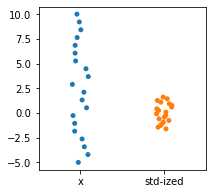

In [30]:
# 1-D standardization
# place evenly spaced values in a dataframe
xs = np.linspace(-5, 10, 20)
df = pd.DataFrame(xs, columns=['x'])

# center ( - mean) and scale (/ std)
df['std-ized'] = (df.x - df.x.mean()) / df.x.std()

# show original and new data; compute statistics
fig, ax = plt.subplots(1,1,figsize=(3,3))
sns.stripplot(data=df)
display(df.describe().loc[['mean', 'std']])

In [31]:
# 2 1-D standardizations
xs = np.linspace(-5, 10, 20)
ys = 3*xs + 2 + np.random.uniform(20, 40, 20)

print("First Row Values")
df = pd.DataFrame({'x':xs, 'y':ys})
display(df.head())

print("Standardized")
df_std_ized = (df - df.mean()) / df.std()
display(df_std_ized.describe().loc[['mean', 'std']])

First Row Values


,x,y
0,-5.0000,9.4408
1,-4.2105,19.2720
2,-3.4211,12.4246
3,-2.6316,32.2917
4,-1.8421,21.6493


Standardized


,x,y
mean,0.0000,-0.0000
std,1.0000,1.0000


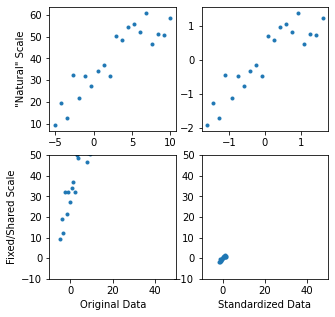

In [32]:
fig, ax = plt.subplots(2,2, figsize=(5,5))

ax[0,0].plot(df.x, df.y, '.')
ax[0,1].plot(df_std_ized.x, df_std_ized.y, '.')
ax[0,0].set_ylabel('"Natural" Scale')

ax[1,0].plot(df.x, df.y, '.')
ax[1,1].plot(df_std_ized.x, df_std_ized.y, '.')

ax[1,0].axis([-10, 50, -10, 50])
ax[1,1].axis([-10, 50, -10, 50])

ax[1,0].set_ylabel('Fixed/Shared Scale')
ax[1,0].set_xlabel('Original Data')
ax[1,1].set_xlabel('Standardized Data');

In [33]:
train_xs, test_xs = skms.train_test_split(xs.reshape(-1,1), test_size=.5)

scaler = skpre.StandardScaler()
scaler.fit(train_xs).transform(test_xs)

array([[-2.43136343],
       [-1.50512975],
       [-2.19980501],
       [ 1.73668817],
       [-1.96824659],
       [ 1.0420129 ],
       [ 0.34733763],
       [-1.27357132],
       [-0.34733763],
       [-2.66292186]])

In [34]:
(train_xs, test_xs,
 train_ys, test_ys)= skms.train_test_split(xs.reshape(-1,1), 
                                           ys.reshape(-1,1),
                                           test_size=.5)

scaler = skpre.StandardScaler()
lr  = linear_model.LinearRegression()

std_lr_pipe  = pipeline.make_pipeline(scaler, lr)

std_lr_pipe.fit(train_xs, train_ys).predict(test_xs)

array([[48.35230942],
       [41.19363429],
       [24.49005898],
       [14.9451588 ],
       [53.12475951],
       [45.96608437],
       [43.57985933],
       [19.71760889],
       [31.64873411],
       [38.80740924]])

# Case Study:  A Regression Comparison

In [35]:
boston = datasets.load_boston()

In [36]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['tgt'] = boston.target
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,tgt
0,0.0063,18.0000,2.3100,0.0000,0.5380,6.5750,65.2000,4.0900,1.0000,296.0000,15.3000,396.9000,4.9800,24.0000
1,0.0273,0.0000,7.0700,0.0000,0.4690,6.4210,78.9000,4.9671,2.0000,242.0000,17.8000,396.9000,9.1400,21.6000
2,0.0273,0.0000,7.0700,0.0000,0.4690,7.1850,61.1000,4.9671,2.0000,242.0000,17.8000,392.8300,4.0300,34.7000
3,0.0324,0.0000,2.1800,0.0000,0.4580,6.9980,45.8000,6.0622,3.0000,222.0000,18.7000,394.6300,2.9400,33.4000
4,0.0691,0.0000,2.1800,0.0000,0.4580,7.1470,54.2000,6.0622,3.0000,222.0000,18.7000,396.9000,5.3300,36.2000


In [37]:
boston_ftrs = boston.data
boston_tgt  = boston.target

In [38]:
models = {'base'  : dummy.DummyRegressor(strategy='mean'),
          'lr'    : linear_model.LinearRegression(),
          'knn_3' : neighbors.KNeighborsRegressor(n_neighbors=3),
          'knn_10': neighbors.KNeighborsRegressor(n_neighbors=10)}

# join these into standarization pipelines
make_p = pipeline.make_pipeline
scaler = skpre.StandardScaler()
pipes = {m:make_p(scaler, models[m]) for m in models}

scorers = {'neg. mae' :metrics.SCORERS['neg_median_absolute_error'],
           'neg. rmse':metrics.SCORERS['neg_root_mean_squared_error']}

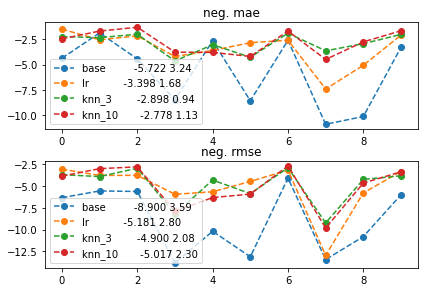

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(6,4))
fig.tight_layout()
for name in pipes:
    p = pipes[name]
    cv_results = skms.cross_validate(p, boston_ftrs, boston_tgt, 
                                     scoring = scorers, cv=10)

    for ax, msr in zip(axes, scorers):
        msr_results = cv_results["test_" + msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(name, 
                                               msr_results.mean(), 
                                               msr_results.std())
        ax.plot(msr_results, 'o--', label=my_lbl)
        ax.set_title(msr)
        ax.legend()

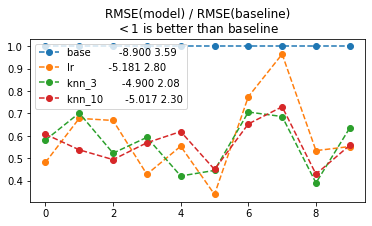

In [40]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
baseline_mse = skms.cross_val_score(models['base'], 
                                    boston_ftrs, boston_tgt, 
                                    scoring = scorers['neg. rmse'], cv=10)

for name in pipes:
    p = pipes[name]
    cv_results = skms.cross_val_score(p, boston_ftrs, boston_tgt, 
                                      scoring = scorers['neg. rmse'], cv=10)

    my_lbl = "{:12s} {:.3f} {:.2f}".format(name, 
                                           cv_results.mean(), 
                                           cv_results.std())

    ax.plot(cv_results / baseline_mse, 'o--', label=my_lbl)
ax.set_title("RMSE(model) / RMSE(baseline)\n$<1$ is better than baseline")
ax.legend();

In [41]:
# this time, just metrics (not scorers)
msrs = {'mad'  : metrics.mean_absolute_error,
        'rmse' : rms_error}

results = {}
for name in pipes:
    p = pipes[name]
    cv_preds = skms.cross_val_predict(p, boston_ftrs, boston_tgt,
                                      cv=10)
    for ax, msr in zip(axes, msrs):
        msr_results = msrs[msr](boston_tgt, cv_preds)
        results.setdefault(msr, []).append(msr_results)
df = pd.DataFrame(results, index=pipes.keys())
df

,mad,rmse
base,7.0394,9.5988
lr,3.9973,5.8770
knn_3,3.6868,5.3205
knn_10,3.7851,5.5154


,count,mean,std,min,25%,50%,75%,max
0,506.0000,22.5328,9.1971,5.0000,17.0250,21.2000,25.0000,50.0000


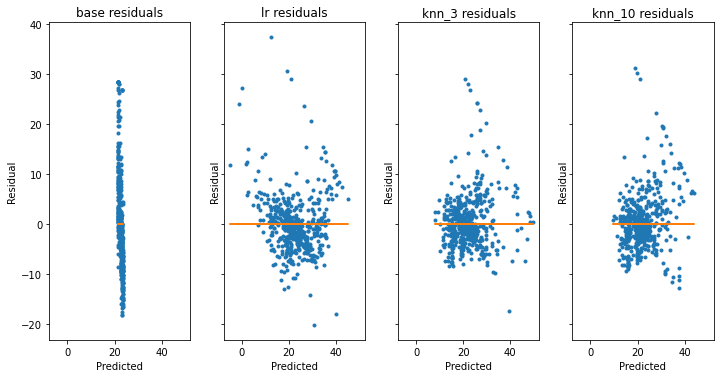

In [42]:
fig, axes = plt.subplots(1, 4, figsize=(10,5), 
                         sharex=True, sharey=True)
fig.tight_layout()

for name, ax in zip(pipes, axes):
    p = pipes[name]
    preds = skms.cross_val_predict(p, boston_ftrs, boston_tgt,
                                   cv=10)
    regression_residuals(ax, preds, boston_tgt)
    ax.set_title(name + " residuals")

pd.DataFrame(boston_tgt).describe().T